<a href="https://colab.research.google.com/github/DSYMaO/STA365/blob/main/STA365_HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import pymc as pm;
import pandas as pd; import arviz as az


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving Maths.csv to Maths.csv


From Kaggle: https://www.kaggle.com/datasets/whenamancodes/student-performance/data

I used the same dataset as the previous homework as it has categorical variables.

In [131]:
df = pd.read_csv('Maths.csv')
print(df)

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   
395     GP   F   18       U     GT3       A     4     4   at_home   teacher   
396     MS   M   19       R     GT3       T     1     1     other  services   

     ... famrel freetime  goout  Dalc  Walc health 

I will use the Medu variable which represents Mother's education level with a range of 1 to 4

In [132]:
X = df[['Fedu', 'G1', 'G2', 'G3']]
y = df['Medu']
n, p = X.shape
n, p

(397, 4)

In [133]:
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros(p), cov=np.eye(p), shape=p)
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0)
    y_obs = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()

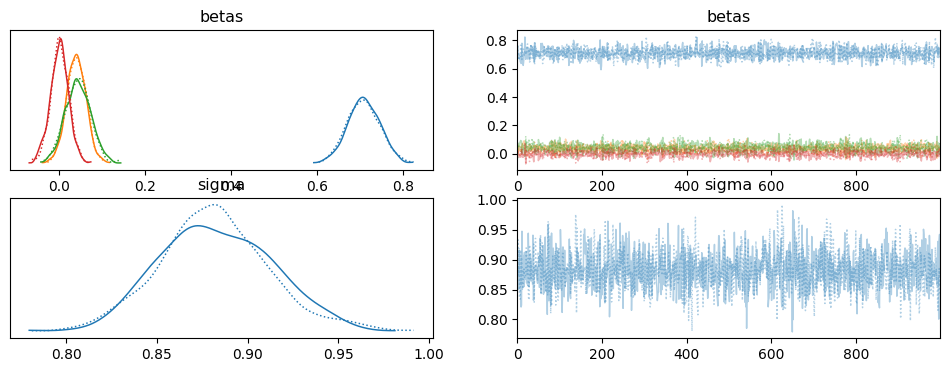

In [134]:
az.plot_trace(idata);


In [135]:
az.summary(idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.709,0.038,0.639,0.781,0.001,0.001,1665.0,1063.0,1.0
betas[1],0.039,0.023,-0.005,0.079,0.001,0.000,1518.0,1352.0,1.0
betas[2],0.043,0.029,-0.011,0.098,0.001,0.001,1078.0,1130.0,1.0
betas[3],0.001,0.021,-0.038,0.045,0.001,0.000,1268.0,1168.0,1.0
sigma,0.882,0.031,0.825,0.942,0.001,0.001,1699.0,1336.0,1.0


In [136]:
with pm.Model() as logit_mod:
    betas = pm.MvNormal('betas', mu=np.zeros(p), cov=np.eye(p), shape=p)
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0)
    p = pm.math.invlogit(pm.math.dot(X, betas))
    y_obs =  pm.Bernoulli('y', logit_p=p, observed=y)

with MLR:
    idata2 = pm.sample()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.709,0.037,0.637,0.775,0.001,0.001,1760.0,1335.0,1.0
betas[1],0.039,0.024,-0.004,0.083,0.001,0.000,1324.0,1355.0,1.0
betas[2],0.045,0.032,-0.021,0.101,0.001,0.001,875.0,803.0,1.0
betas[3],-0.001,0.023,-0.043,0.041,0.001,0.001,956.0,947.0,1.0
sigma,0.881,0.031,0.821,0.938,0.001,0.001,1691.0,1324.0,1.0


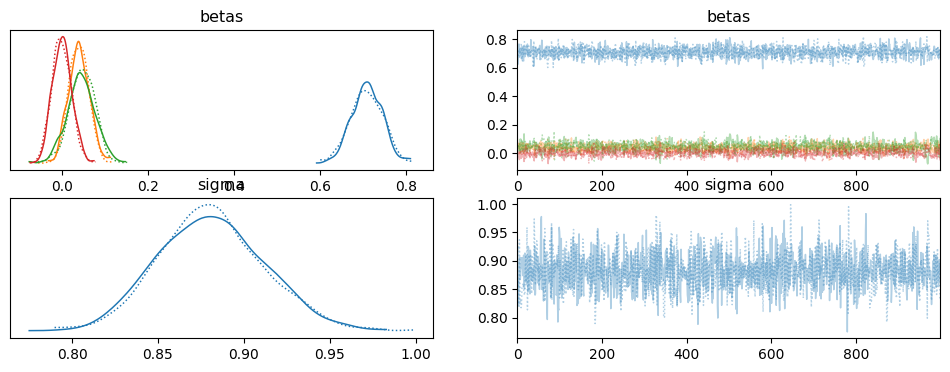

In [138]:
az.plot_trace(idata2);
az.summary(idata2)

 I transformed the model using pm.math.invlogit of the X * betas which should then act as the parameter for the Bernoulli sampling. We see some differences in the trace plots.

### Q2

\begin{align*}
\beta_i \sim {} & \text{Laplace}(b_i,s_i) & f(\beta_i| b_i, s_i) = {}& {\frac  {1}{2b}}\exp \left(-{\frac{|\beta_i-b_i |}{s_i}}\right) & \overbrace{\underbrace{|\beta_i-b_i|}}_{\text{Absolute Penalization}}^{L_1}\\
y_i \sim {} & \text{Normal}(x_i^T\beta, \sigma) & \sigma \sim {} & \text{HalfNormal}(\sigma_0)
\end{align*}

For $\sigma=1$ and $b_i=0$, and $s_i$ = 1/λ
\begin{align*}
log(f(\beta_i| b_i, s_i)) = {}& { \log \frac {1}{2b}}\exp \left(-{\frac{|\beta_i-b_i |}{s_i}}\right)
= \log {\frac {1}{2b}} - \frac {|\beta_i|}{s_i}\\
= \log {\frac {1}{2b}} - \lambda|\beta_i|
\end{align*}
which are analagous form of the ridge regression with the $L_1$ penalty